loaded cifar100 vit_base_patch16_224 baseline 0
loaded cifar100 vit_base_patch16_224 L1 200
loaded cifar100 vit_base_patch16_224 L1 1000
loaded cifar100 vit_base_patch16_224 L1 20000
loaded cifar100 vit_base_patch16_224 spatial 162
loaded cifar100 vit_base_patch16_224 spatial-learn 20
loaded cifar100 vit_base_patch16_224 spatial-learn 40
loaded cifar100 vit_base_patch16_224 spatial-learn 120
loaded cifar100 resnet101 L1 500
loaded cifar100 resnet101 spatial-swap 120
loaded cifar100 resnet101 spatial-swap 162
loaded cifar100 resnet101 spatial-swap 325
loaded cifar100 resnet101 spatial-swap 1300
loaded cifar100 resnet101 spatial-learn 20
loaded cifar100 resnet101 spatial-learn 40
loaded cifar100 resnet101 spatial-learn 5000
loaded cifar100 resnet101 spatial-both 650
loaded cifar100 efficientnet_b0 L1 2000
loaded cifar100 efficientnet_b0 L1 20000
loaded cifar100 efficientnet_b0 spatial 162
loaded cifar100 efficientnet_b0 spatial 1300
loaded cifar100 efficientnet_b0 spatial-swap 40
loaded 

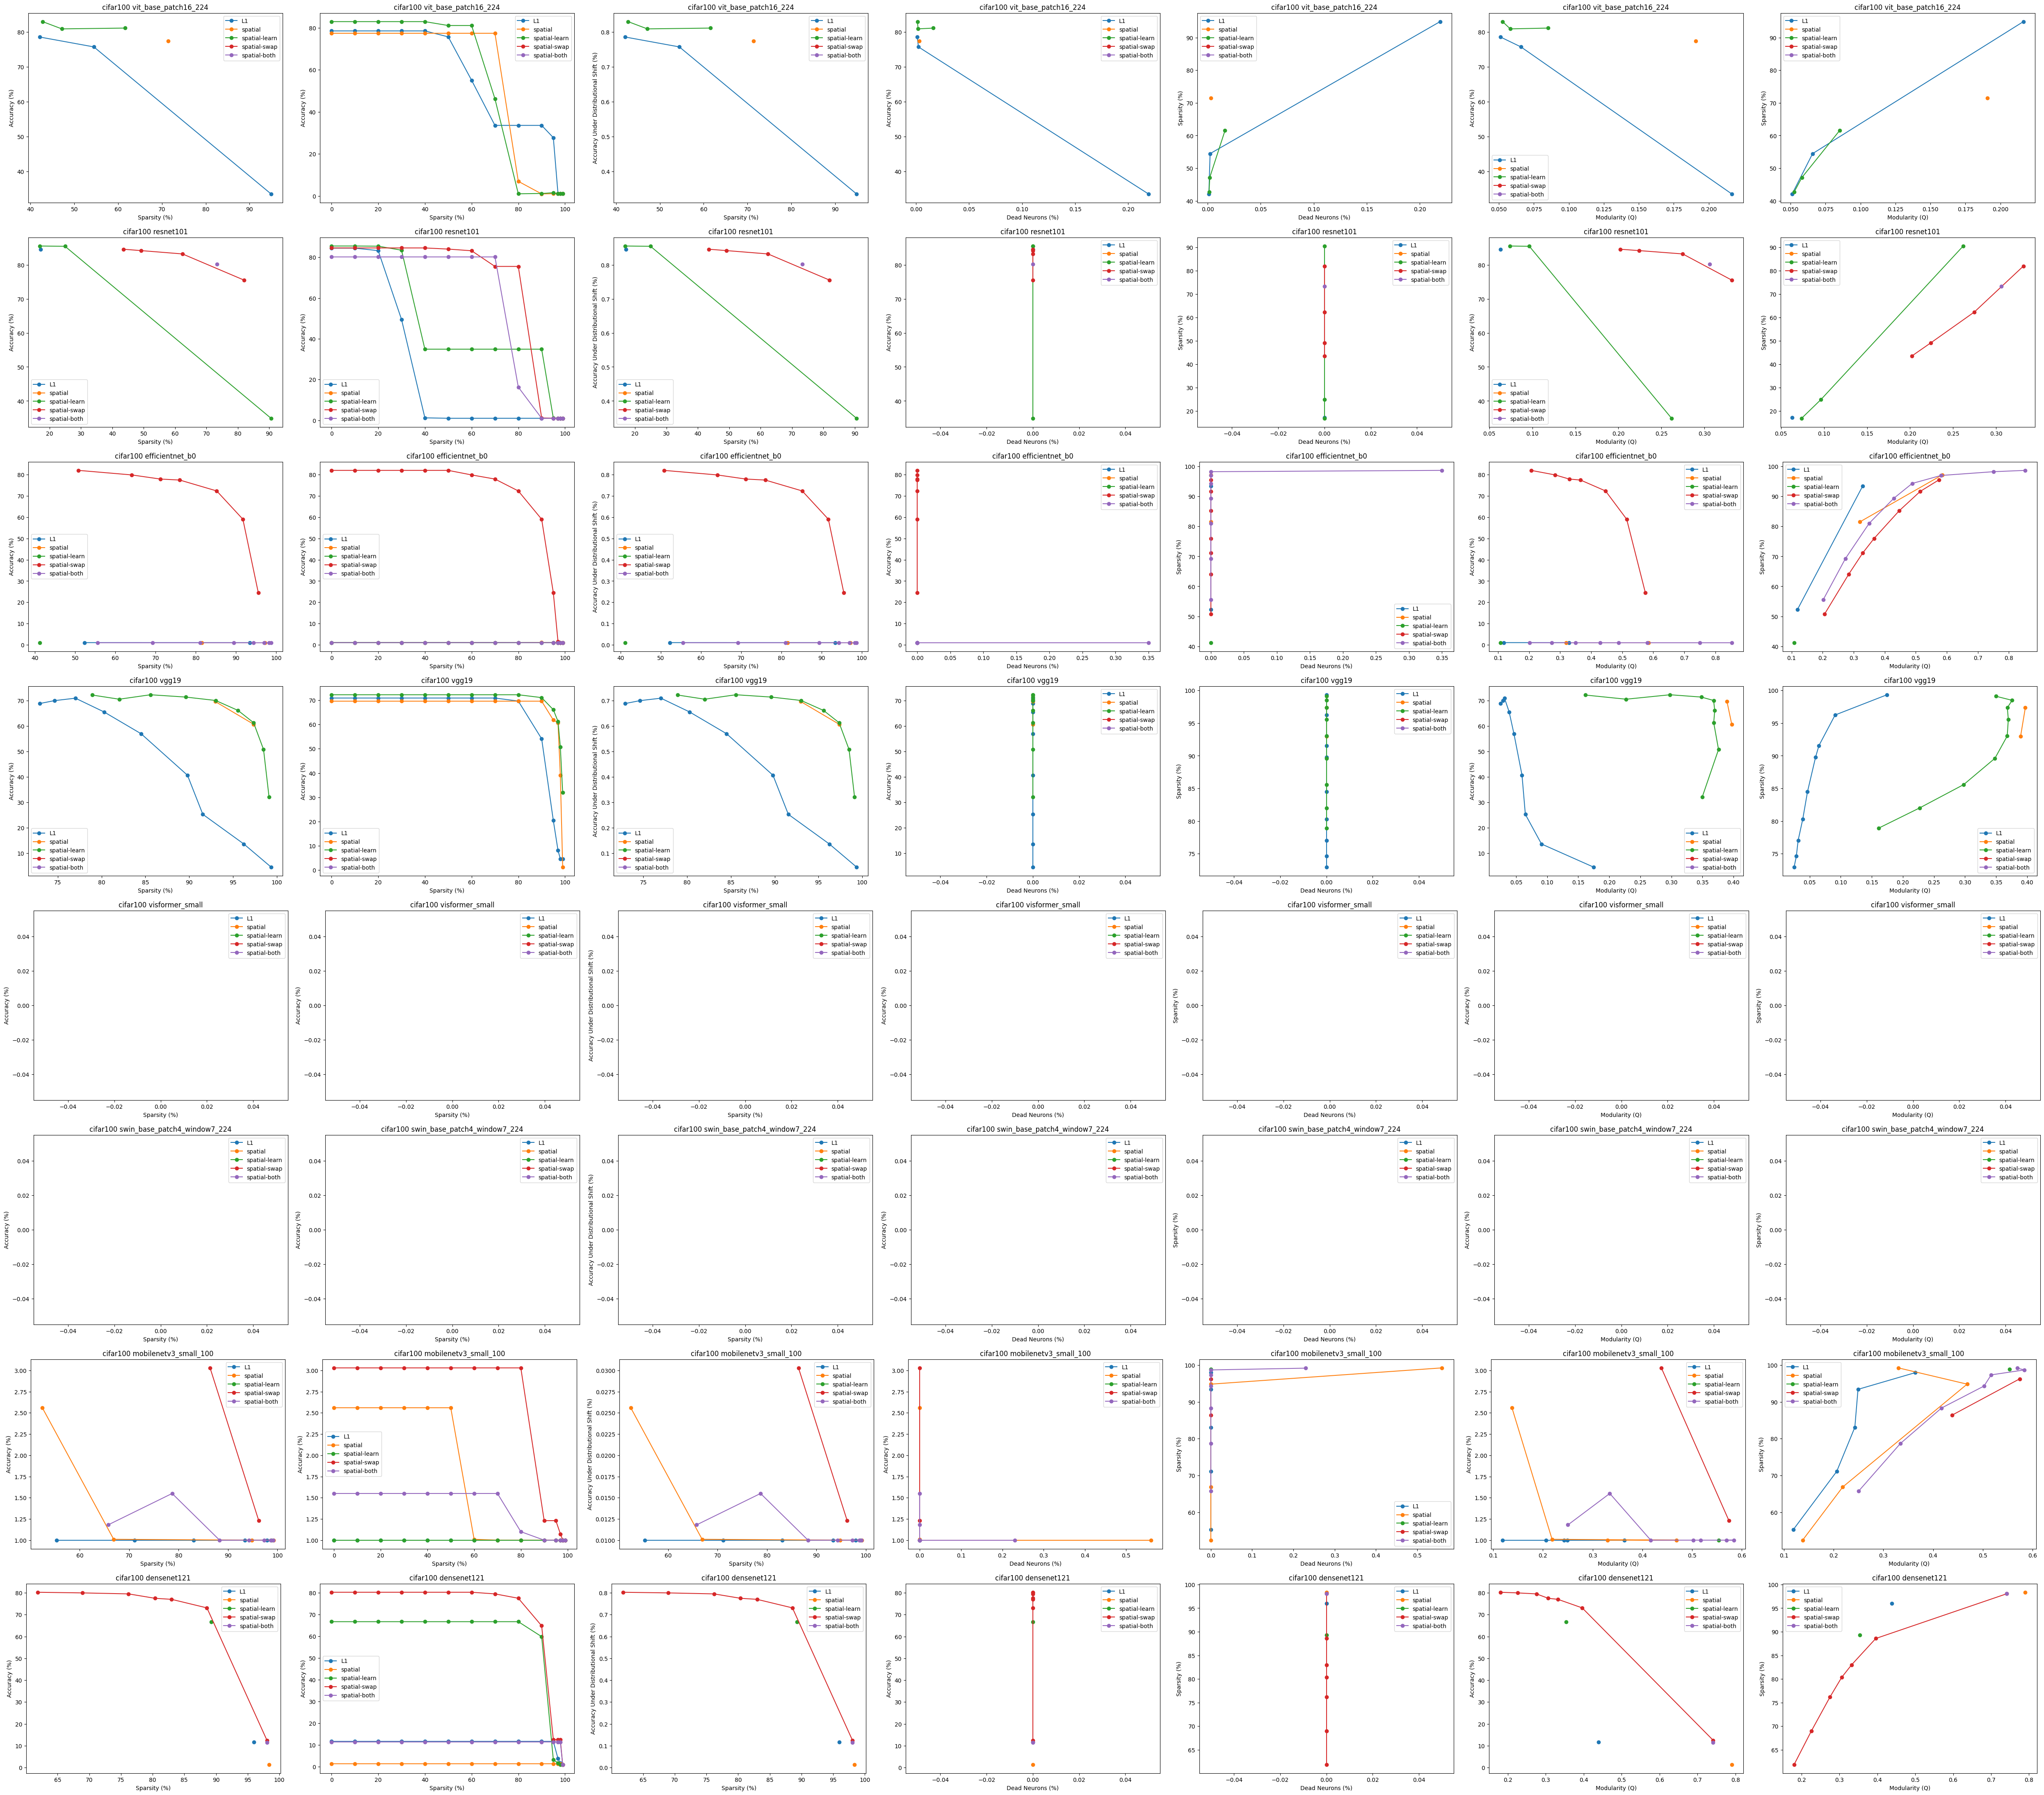

In [11]:
import util
import glob
import timm
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import pickle
import os
from collections import defaultdict

def stringify_keys(obj):
    """
    Recursively convert all keys in a nested dict to strings.
    If values are lists or tuples, recurse into their elements.
    Other types are returned unchanged.
    """
    if isinstance(obj, dict):
        return {str(key): stringify_keys(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [stringify_keys(item) for item in obj]
    elif isinstance(obj, tuple):
        return tuple(stringify_keys(item) for item in obj)
    else:
        return obj


# datasets = ['cifar100','cifar10',"pets","tiny_imagenet",'svhn','birds','caltech101','DTD']
# models = ["vit_tiny_patch16_224","resnet50"]

datasets = ['cifar100']
models = ['vit_base_patch16_224','resnet101','efficientnet_b0','vgg19','visformer_small','swin_base_patch4_window7_224','mobilenetv3_small_100','densenet121']


modes = {
    "baseline": [0],
    "L1" : [50, 200, 500, 1000, 2000, 4000, 5000, 10000, 20000, 40000],
    "spatial": [20,40,80,120,162,325,650,1300,2600,5000],
    "spatial-swap": [20,40,80,120,162,325,650,1300,2600,5000],
    "spatial-learn":[20,40,80,120,162,325,650,1300,2600,5000],
    "spatial-both": [20,40,80,120,162,325,650,1300,2600,5000],
}


results = defaultdict(lambda:  defaultdict(lambda:  defaultdict(lambda: {})))
for dataset in datasets:
    for model in models:
        for mode, gammas in modes.items():
            for gamma in gammas:
                path = dataset +"/" + mode + "/" 
                file_name = mode + ":" +model+":"+str(gamma) 
                name = "./metrics/"+path+ file_name +'.pkl'
                if os.path.exists(name):
                    with open(name, 'rb') as f:
                        result = pickle.load(f)
                    result = stringify_keys(result)
                    results[dataset][model][mode][gamma]=result
                    print("loaded",dataset,model,mode,gamma)


images=[]
for dataset in datasets:
    for model in models:

        y_axis = "final_acc"
        x_axis = "percent_below_t"#"percent_dead_neurons" # "modularity" # "percent_below_t"
        ylabel = "Accuracy (%)"
        xlabel = "Sparsity (%)"
        threshold = "0.001"
        modes = ["L1","spatial","spatial-learn","spatial-swap","spatial-both"]
        title = f"{dataset} {model}"

        lists=[]
        labels=[]
        for mode in modes:
            metrics=[]
            for gamma in results[dataset][model][mode].keys():
                try:
                    metrics.append((float((results[dataset][model][mode][gamma][threshold][y_axis])), float(results[dataset][model][mode][gamma][threshold][x_axis])))
                except:
                    print("empty", dataset,mode,model,gamma)
                    print(results[dataset][model][mode][gamma])
            lists.append(metrics)
            labels.append(mode)
        sparse_acc_img = util.plot_lists(lists, title=title, xlabel=xlabel, ylabel=ylabel, labels=labels)


        lists=[]
        labels=[]
        for mode in modes:
            temp = []
            max_tuples=[]
            for p in [100,90,80,70,60,50,40,30,20,10,5,3,2,1]:
                gammas =  [x for x in results[dataset][model][mode].keys()]
                try:
                    temp = [(results[dataset][model][mode][gamma][str(p)][y_axis],100-p) for gamma in gammas]
                except:
                    pass
                    #print("empty", dataset,mode,model,gamma)
                if len(temp)==0:
                    continue
                max_tuple = max(temp, key=lambda x: x[0])
                max_tuples.append(max_tuple)
            lists.append(max_tuples)
            labels.append(mode)
        spares_acc_max_img = util.plot_lists(lists, title=title, xlabel=xlabel, ylabel=ylabel, labels=labels)


        y_axis = "final_acc"
        x_axis = "percent_dead_neurons"#"percent_dead_neurons" # "modularity" # "percent_below_t"
        ylabel = "Accuracy (%)"
        xlabel = "Dead Neurons (%)"
        threshold = "0.001"
        modes = ["L1","spatial","spatial-learn","spatial-swap","spatial-both"]
        title = f"{dataset} {model}"

        lists=[]
        labels=[]
        for mode in modes:
            metrics=[]
            for gamma in results[dataset][model][mode].keys():
                try:
                    metrics.append((float((results[dataset][model][mode][gamma][threshold][y_axis])), float(results[dataset][model][mode][gamma][threshold][x_axis])))
                except:
                    pass
            lists.append(metrics)
            labels.append(mode)
        dead_acc_img = util.plot_lists(lists, title=title, xlabel=xlabel, ylabel=ylabel, labels=labels)

        y_axis = "percent_below_t"
        x_axis = "percent_dead_neurons"#"percent_dead_neurons" # "modularity" # "percent_below_t"
        ylabel = "Sparsity (%)"
        xlabel = "Dead Neurons (%)"
        threshold = "0.001"
        modes = ["L1","spatial","spatial-learn","spatial-swap","spatial-both"]
        title = f"{dataset} {model}"

        lists=[]
        labels=[]
        for mode in modes:
            metrics=[]
            for gamma in results[dataset][model][mode].keys():
                try:
                    metrics.append((float((results[dataset][model][mode][gamma][threshold][y_axis])), float(results[dataset][model][mode][gamma][threshold][x_axis])))
                except:
                    pass
            lists.append(metrics)
            labels.append(mode)
        dead_sparse_img = util.plot_lists(lists, title=title, xlabel=xlabel, ylabel=ylabel, labels=labels)


        y_axis = "final_acc"
        x_axis = "modularity"#"percent_dead_neurons" # "modularity" # "percent_below_t"
        ylabel = "Accuracy (%)"
        xlabel = "Modularity (Q)"
        threshold = "0.001"
        modes = ["L1","spatial","spatial-learn","spatial-swap","spatial-both"]
        title = f"{dataset} {model}"

        lists=[]
        labels=[]
        for mode in modes:
            metrics=[]
            for gamma in results[dataset][model][mode].keys():
                try:
                    metrics.append((float((results[dataset][model][mode][gamma][threshold][y_axis])), float(results[dataset][model][mode][gamma][threshold][x_axis])))
                except:
                    pass
            lists.append(metrics)
            labels.append(mode)
        modularity_acc_img = util.plot_lists(lists, title=title, xlabel=xlabel, ylabel=ylabel, labels=labels)


        y_axis = "percent_below_t"
        x_axis = "modularity"#"percent_dead_neurons" # "modularity" # "percent_below_t"
        ylabel = "Sparsity (%)"
        xlabel = "Modularity (Q)"
        threshold = "0.001"
        modes = ["L1","spatial","spatial-learn","spatial-swap","spatial-both"]
        title = f"{dataset} {model}"

        lists=[]
        labels=[]
        for mode in modes:
            metrics=[]
            for gamma in results[dataset][model][mode].keys():
                try:
                    metrics.append((float((results[dataset][model][mode][gamma][threshold][y_axis])), float(results[dataset][model][mode][gamma][threshold][x_axis])))
                except:
                    pass
            lists.append(metrics)
            labels.append(mode)
        modularity_sparse_img = util.plot_lists(lists, title=title, xlabel=xlabel, ylabel=ylabel, labels=labels)


        y_axis = "shift_accuracy"
        x_axis = "percent_below_t"#"percent_dead_neurons" # "modularity" # "percent_below_t"
        ylabel = "Accuracy Under Distributional Shift (%)"
        xlabel = "Sparsity (%)"
        threshold = "0.001"
        modes = ["L1","spatial","spatial-learn","spatial-swap","spatial-both"]
        title = f"{dataset} {model}"

        lists=[]
        labels=[]
        for mode in modes:
            metrics=[]
            for gamma in results[dataset][model][mode].keys():
                try:
                    metrics.append((float((results[dataset][model][mode][gamma][threshold][y_axis])), float(results[dataset][model][mode][gamma][threshold][x_axis])))
                except:
                    pass
            lists.append(metrics)
            labels.append(mode)
        robust_sparse_img = util.plot_lists(lists, title=title, xlabel=xlabel, ylabel=ylabel, labels=labels)



        row = [sparse_acc_img,spares_acc_max_img, robust_sparse_img, dead_acc_img,dead_sparse_img,modularity_acc_img,modularity_sparse_img]

        images.append(row)
# util.make_image_grid([[image1,image2]])
util.make_image_grid(images)

In [ ]:
import json

def dict_to_json(input_dict):
    """
    Takes a Python dict and returns its JSON string representation.
    """
    try:
        json_str = json.dumps(input_dict)
        return json_str
    except (TypeError, ValueError) as e:
        raise ValueError(f"Provided dict contains non-serializable values: {e}")


{"name": "Alice", "age": 30, "languages": ["English", "Spanish"], "profile": {"active": true, "score": null}}
